In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tqdm import tqdm
import json

file_path = '/Users/sakshamjain/Desktop/SPOTIFY 2.0/69.csv'  
data = pd.read_csv(file_path)

# Load the JSON file
json_file_path = '/Users/sakshamjain/Desktop/SPOTIFY 2.0/selected_users.json'
with open(json_file_path, 'r') as f:
    user_data = json.load(f)


track_popularity = data['track_popularity']
min_value = data['track_popularity'].min()
max_value = data['track_popularity'].max()


In [4]:
# Define the similarity function using these extracted values
def absolute_difference_similarity(value1, value2, min_val, max_val):
    
    max_possible_difference = max_val - min_val
    difference = abs(value1 - value2)
    similarity = 1 - (difference / max_possible_difference)
    return similarity


def sentiment_similarity_combined(vector1, vector2, alpha_sentiment=0.5):
   
    cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    euc_dist = euclidean_distances(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    max_dist = np.sqrt(len(vector1))
    euc_sim = 1 - (euc_dist / max_dist)
    combined_sim = alpha_sentiment * cos_sim + (1 - alpha_sentiment) * euc_sim
    return combined_sim

def lyrics_embedding_similarity(vector1, vector2):
    return cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]


def combined_audio_similarity(vector1, vector2, alpha_audio=0.5):

    cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    euc_dist = euclidean_distances(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    max_dist = np.sqrt(len(vector1))
    euc_sim = 1 - (euc_dist / max_dist)
    combined_sim = alpha_audio * cos_sim + (1 - alpha_audio) * euc_sim
    return combined_sim

def lyrics_language_similarity(lang1, lang2):
    return 1 if lang1 == lang2 else 0



In [5]:
def calculate_similarity(data, index1, index2, weight_popularity=0.2, weight_audio=0.4, weight_language=0.1, weight_sentiment=0.2, weight_lyrics_embedding=0.1, alpha_audio=0.5, alpha_sentiment=0.5):
    song1 = data.iloc[index1]
    song2 = data.iloc[index2]

    popularity_sim = absolute_difference_similarity(song1['track_popularity'], song2['track_popularity'],min_val=min_value,max_val=max_value)

    audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    vector1 = song1[audio_features].values
    vector2 = song2[audio_features].values

    audio_sim = combined_audio_similarity(vector1.astype(float), vector2.astype(float), alpha_audio)

    language_sim = lyrics_language_similarity(song1['lyrics_language'], song2['lyrics_language'])

    sentiment_features = ['lyrics_joy', 'lyrics_sadness', 'lyrics_anger', 'lyrics_fear', 'lyrics_surprise', 'lyrics_disgust']
    sentiment_vector1 = song1[sentiment_features].values
    sentiment_vector2 = song2[sentiment_features].values
    sentiment_sim = sentiment_similarity_combined(sentiment_vector1.astype(float), sentiment_vector2.astype(float), alpha_sentiment)

    lyrics_embedding_features = [f'lyrics_lyric_embed_{i}' for i in range(768)]
    lyrics_embedding_vector1 = song1[lyrics_embedding_features].values
    lyrics_embedding_vector2 = song2[lyrics_embedding_features].values
    lyrics_embedding_sim = lyrics_embedding_similarity(lyrics_embedding_vector1.astype(float), lyrics_embedding_vector2.astype(float))

    overall_similarity = (weight_popularity * popularity_sim) + (weight_audio * audio_sim) + (weight_language * language_sim) + (weight_sentiment * sentiment_sim) + (weight_lyrics_embedding * lyrics_embedding_sim)
    return overall_similarity, popularity_sim, audio_sim, language_sim, sentiment_sim, lyrics_embedding_sim


In [6]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.025]
weight_lyrics_embedding_values = [0.005]
weight_audio_values = [0.005]
weight_sentiment_values = [0.95]
weight_language_values = [0.015]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results69.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0              0.025         0.005            0.015              0.95   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                    0.005           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                    0.737257                0.682462  


In [10]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.15]
weight_lyrics_embedding_values = [0.005]
weight_audio_values = [0.005]
weight_sentiment_values = [0.825]
weight_language_values = [0.015]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results69.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.15, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.825, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0               0.15         0.005            0.015             0.825   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                    0.005           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                    0.733671                0.668615  


In [11]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.1]
weight_lyrics_embedding_values = [0]
weight_audio_values = [0]
weight_sentiment_values = [0.9]
weight_language_values = [0]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results69.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.1, weight_audio=0, weight_language=0, weight_sentiment=0.9, weight_lyrics_embedding=0, alpha_audio=1, alpha_sentiment=0


   weight_popularity weight_audio weight_language  weight_sentiment  \
0                0.1            0               0               0.9   

  weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                       0           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                     0.74439                0.708308  


In [12]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.05]
weight_lyrics_embedding_values = [0.01]
weight_audio_values = [0.01]
weight_sentiment_values = [0.9]
weight_language_values = [0.03]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results69.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.05, weight_audio=0.01, weight_language=0.03, weight_sentiment=0.9, weight_lyrics_embedding=0.01, alpha_audio=1, alpha_sentiment=0


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0               0.05          0.01             0.03               0.9   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                     0.01           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                    0.727255                0.644615  


In [13]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.1]
weight_lyrics_embedding_values = [0.01]
weight_audio_values = [0.01]
weight_sentiment_values = [0.85]
weight_language_values = [0.03]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results8.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.1, weight_audio=0.01, weight_language=0.03, weight_sentiment=0.85, weight_lyrics_embedding=0.01, alpha_audio=1, alpha_sentiment=0


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0                0.1          0.01             0.03              0.85   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                     0.01           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                     0.72582                0.639077  


In [14]:
## Define hyperparameter ranges
weight_popularity_values = [0.075]
weight_lyrics_embedding_values = [0.02]
weight_audio_values = [0.02]
weight_sentiment_values = [0.85]
weight_language_values = [0.035]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results8.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.075, weight_audio=0.02, weight_language=0.035, weight_sentiment=0.85, weight_lyrics_embedding=0.02, alpha_audio=1, alpha_sentiment=0


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0              0.075          0.02            0.035              0.85   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                     0.02           1               0   

   final_avg_similarity_score  final_overall_accuracy  
0                    0.712587                0.571692  


In [6]:
def evaluate_playlist(playlist, data, threshold, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None, None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None, None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    accuracy = 1 if avg_similarity >= threshold else 0

    return avg_similarity, accuracy



## Define hyperparameter ranges
weight_popularity_values = [0.025]
weight_lyrics_embedding_values = [0.005]
weight_audio_values = [0.005]
weight_sentiment_values = [0.95]
weight_language_values = [0.015]

alpha_audio_values = [1,0.8]
alpha_sentiment_values = [0,0.2]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")


# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'final_overall_accuracy'
])

# Analyze each user's playlist for each combination of hyperparameters
results = []

combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Processing playlists for combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity, accuracy = evaluate_playlist(playlist, data, 0.7, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
)
                                    if avg_similarity is not None and accuracy is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity,
                                            'Accuracy': accuracy
                                        })
                                
                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()
                                    final_overall_accuracy = temp_df['Accuracy'].sum() / len(temp_df)
                                    
                                    # Create a DataFrame for the current combination result
                                    current_result_df = pd.DataFrame([{
                                        'weight_popularity': weight_popularity,
                                        'weight_audio': weight_audio,
                                        'weight_language': weight_language,
                                        'weight_sentiment': weight_sentiment,
                                        'weight_lyrics_embedding': weight_lyrics_embedding,
                                        'alpha_audio': alpha_audio,
                                        'alpha_sentiment': alpha_sentiment,
                                        'final_avg_similarity_score': final_avg_similarity_score,
                                        'final_overall_accuracy': final_overall_accuracy
                                    }])

                                    # Append the current result DataFrame to the final results DataFrame
                                    final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

                                    # Optionally save the DataFrame to a file after each iteration to ensure progress is not lost
                                    final_results_df.to_csv('intermediate_results69.csv', index=False)

# Print the final results
print(final_results_df)


Total number of valid hyperparameter combinations: 4
Combination 1/4: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0


Combination 2/4: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0.2


Combination 3/4: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=0.8, alpha_sentiment=0


Combination 4/4: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=0.8, alpha_sentiment=0.2


   weight_popularity  weight_audio  weight_language  weight_sentiment  \
0              0.025         0.005            0.015              0.95   
1              0.025         0.005            0.015              0.95   
2              0.025         0.005            0.015              0.95   
3              0.025         0.005            0.015              0.95   

   weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                    0.005           1               0   
1                    0.005           1             0.2   
2                    0.005         0.8               0   
3                    0.005         0.8             0.2   

   final_avg_similarity_score  final_overall_accuracy  
0                    0.737257                0.682462  
1                    0.695207                0.505231  
2                    0.736914                0.681231  
3                    0.694864                0.503692  


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0


     weight_popularity  weight_audio  weight_language  weight_sentiment  \
0                0.025         0.005            0.015              0.95   
1                0.025         0.005            0.015              0.95   
2                0.025         0.005            0.015              0.95   
3                0.025         0.005            0.015              0.95   
4                0.025         0.005            0.015              0.95   
..                 ...           ...              ...               ...   
96               0.025         0.005            0.015              0.95   
97               0.025         0.005            0.015              0.95   
98               0.025         0.005            0.015              0.95   
99               0.025         0.005            0.015              0.95   
100              0.025         0.005            0.015              0.95   

     weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                      0.005           

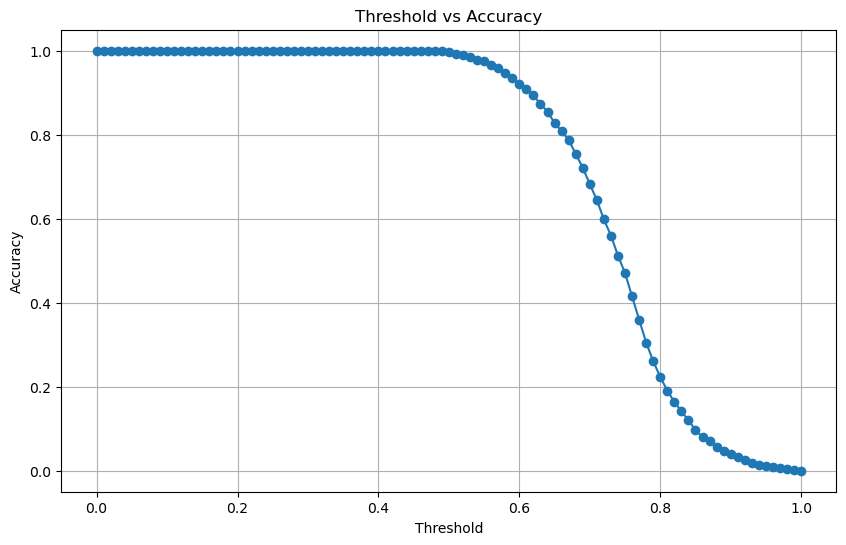

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_playlist(playlist, data, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    return avg_similarity

## Define hyperparameter ranges
weight_popularity_values = [0.025]
weight_lyrics_embedding_values = [0.005]
weight_audio_values = [0.005]
weight_sentiment_values = [0.95]
weight_language_values = [0.015]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")

# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'threshold', 'accuracy'
])

# Thresholds and accuracy results
thresholds = np.arange(0, 1.01, 0.01)

# Analyze each user's playlist for each combination of hyperparameters
combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity = evaluate_playlist(playlist, data, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment)
                                    if avg_similarity is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity
                                        })

                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()

                                    for threshold in thresholds:
                                        accuracy = (temp_df['AverageSimilarityScore'] >= threshold).mean()

                                        # Create a DataFrame for the current combination result and threshold
                                        current_result_df = pd.DataFrame([{
                                            'weight_popularity': weight_popularity,
                                            'weight_audio': weight_audio,
                                            'weight_language': weight_language,
                                            'weight_sentiment': weight_sentiment,
                                            'weight_lyrics_embedding': weight_lyrics_embedding,
                                            'alpha_audio': alpha_audio,
                                            'alpha_sentiment': alpha_sentiment,
                                            'final_avg_similarity_score': final_avg_similarity_score,
                                            'threshold': threshold,
                                            'accuracy': accuracy
                                        }])

                                        # Append the current result DataFrame to the final results DataFrame
                                        final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

# Print the final results
print(final_results_df)

# Calculate and plot accuracy for each threshold
threshold_accuracy = final_results_df.groupby('threshold')['accuracy'].mean()

plt.figure(figsize=(10, 6))
plt.plot(threshold_accuracy.index, threshold_accuracy.values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy')
plt.grid(True)
plt.show()


Total number of valid hyperparameter combinations: 1
Combination 1/1: weight_popularity=0.025, weight_audio=0.005, weight_language=0.015, weight_sentiment=0.95, weight_lyrics_embedding=0.005, alpha_audio=1, alpha_sentiment=0


      weight_popularity  weight_audio  weight_language  weight_sentiment  \
0                 0.025         0.005            0.015              0.95   
1                 0.025         0.005            0.015              0.95   
2                 0.025         0.005            0.015              0.95   
3                 0.025         0.005            0.015              0.95   
4                 0.025         0.005            0.015              0.95   
...                 ...           ...              ...               ...   
996               0.025         0.005            0.015              0.95   
997               0.025         0.005            0.015              0.95   
998               0.025         0.005            0.015              0.95   
999               0.025         0.005            0.015              0.95   
1000              0.025         0.005            0.015              0.95   

      weight_lyrics_embedding alpha_audio alpha_sentiment  \
0                       0.

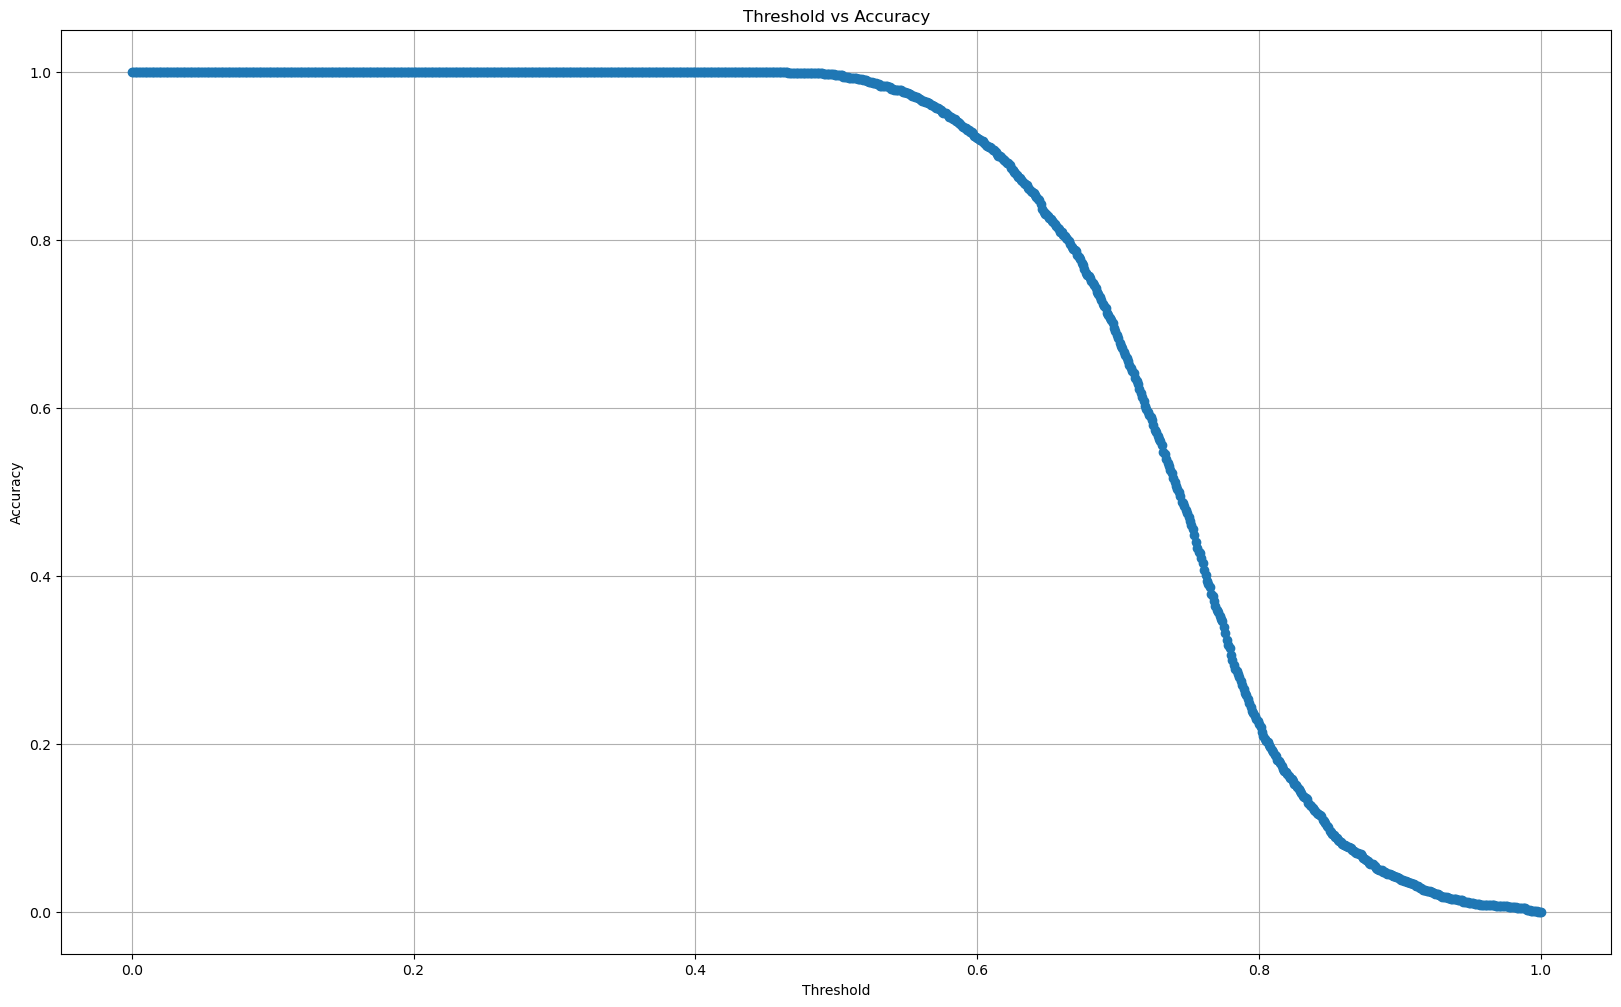

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_playlist(playlist, data, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment):
    last_song_index = data[data['song_id'] == playlist[-1]].index
    if last_song_index.empty:
        print(f"Skipping playlist because the last song with ID {playlist[-1]} was not found in the data.")
        return None  # Skip this playlist if the last song is not found

    last_song_index = last_song_index[0]
    similarities = []

    for song_id in playlist[:-1]:
        song_index = data[data['song_id'] == song_id].index
        if song_index.empty:
            continue  # Skip this song if it is not found
        song_index = song_index[0]
        overall_similarity, _, _, _, _, _ = calculate_similarity(
            data, last_song_index, song_index, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment
        )
        similarities.append(overall_similarity)

    if not similarities:
        return None  # Return None if no valid comparisons were made

    avg_similarity = np.mean(similarities)
    return avg_similarity

## Define hyperparameter ranges
weight_popularity_values = [0.025]
weight_lyrics_embedding_values = [0.005]
weight_audio_values = [0.005]
weight_sentiment_values = [0.95]
weight_language_values = [0.015]

alpha_audio_values = [1]
alpha_sentiment_values = [0]

# Calculate the total number of possible combinations
total_combinations = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                total_combinations += 1

print(f"Total number of valid hyperparameter combinations: {total_combinations}")

# Initialize an empty DataFrame
final_results_df = pd.DataFrame(columns=[
    'weight_popularity', 'weight_audio', 'weight_language', 
    'weight_sentiment', 'weight_lyrics_embedding', 
    'alpha_audio', 'alpha_sentiment', 
    'final_avg_similarity_score', 'threshold', 'accuracy'
])

# Thresholds and accuracy results
thresholds = np.arange(0, 1.001, 0.001)

# Analyze each user's playlist for each combination of hyperparameters
combination_counter = 0
for weight_popularity in weight_popularity_values:
    for weight_lyrics_embedding in weight_lyrics_embedding_values:
        for weight_audio in weight_audio_values:
            for weight_sentiment in weight_sentiment_values:
                for weight_language in weight_language_values:
                    if weight_popularity + weight_lyrics_embedding + weight_audio + weight_sentiment + weight_language == 1:
                        for alpha_audio in alpha_audio_values:
                            for alpha_sentiment in alpha_sentiment_values:
                                combination_counter += 1
                                temp_results = []
                                print(f"Combination {combination_counter}/{total_combinations}: "
                                      f"weight_popularity={weight_popularity}, weight_audio={weight_audio}, "
                                      f"weight_language={weight_language}, weight_sentiment={weight_sentiment}, "
                                      f"weight_lyrics_embedding={weight_lyrics_embedding}, alpha_audio={alpha_audio}, "
                                      f"alpha_sentiment={alpha_sentiment}")
                                for user in tqdm(user_data, desc=f"Combination {combination_counter}/{total_combinations}", leave=False):
                                    user_id = user['UserID']
                                    playlist = user['SongIDs']

                                    avg_similarity = evaluate_playlist(playlist, data, weight_popularity, weight_audio, weight_language, weight_sentiment, weight_lyrics_embedding, alpha_audio, alpha_sentiment)
                                    if avg_similarity is not None:
                                        temp_results.append({
                                            'UserID': user_id,
                                            'AverageSimilarityScore': avg_similarity
                                        })

                                if temp_results:
                                    temp_df = pd.DataFrame(temp_results)
                                    final_avg_similarity_score = temp_df['AverageSimilarityScore'].mean()

                                    for threshold in thresholds:
                                        accuracy = (temp_df['AverageSimilarityScore'] >= threshold).mean()

                                        # Create a DataFrame for the current combination result and threshold
                                        current_result_df = pd.DataFrame([{
                                            'weight_popularity': weight_popularity,
                                            'weight_audio': weight_audio,
                                            'weight_language': weight_language,
                                            'weight_sentiment': weight_sentiment,
                                            'weight_lyrics_embedding': weight_lyrics_embedding,
                                            'alpha_audio': alpha_audio,
                                            'alpha_sentiment': alpha_sentiment,
                                            'final_avg_similarity_score': final_avg_similarity_score,
                                            'threshold': threshold,
                                            'accuracy': accuracy
                                        }])

                                        # Append the current result DataFrame to the final results DataFrame
                                        final_results_df = pd.concat([final_results_df, current_result_df], ignore_index=True)

# Print the final results
print(final_results_df)

# Calculate and plot accuracy for each threshold
threshold_accuracy = final_results_df.groupby('threshold')['accuracy'].mean()

plt.figure(figsize=(20, 12))
plt.plot(threshold_accuracy.index, threshold_accuracy.values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy')
plt.grid(True)
plt.show()
